In [22]:
import torch
import numpy as np
from modeling import IsingEnergyModel
from spin import create_J_matrix, state_to_spin
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [76]:
from torch.distributions.categorical import Categorical

class SimpleIsingTBFlowModel(torch.nn.Module):
    def __init__(self, N, n_hidden=256):
        super().__init__()
        self.N = int(N)
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2 * self.N**2, n_hidden),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(n_hidden, 2 * 2 * self.N**2))
        self.logZ = torch.nn.Parameter(torch.ones(1) * self.N)
        
    def forward(self, state):
        unavailable_actions = torch.cat([state[:,:self.N**2] + state[:,self.N**2:]]*2, dim=-1)
        logits = self.net(state)
        PF = logits[..., :2*self.N**2] * (1 - unavailable_actions) + unavailable_actions * -100
        PB = logits[..., 2*self.N**2:] * state + (1 - state) * -100 # Pas sur si je devrais utiliser le masque ici?
        return PF, PB
    
    def create_new_state_from_choice(self, state, choice):
        base = torch.zeros_like(state)
        base[torch.arange(base.shape[0], dtype=torch.int64), choice] = 1
        new_state = state + base
        return new_state

In [77]:
def create_empty_state(N):
    return torch.zeros(2*(N**2), dtype=torch.float32, requires_grad=True)

def create_input_batch(N, batch_size, device="cpu"):
    return torch.cat([create_empty_state(N).reshape(1,-1)] * batch_size, dim=0).to(device)

In [78]:
def choose_trajectory_and_get_metrics(model, state):
    N = model.N
    
    PF, PB = model(state)
    traj_PF, traj_PB = 0, 0

    for step in range(1, N**2 + 1):
        categorical = Categorical(logits=PF)
        choice = categorical.sample()
        new_state = model.create_new_state_from_choice(state, choice)
        traj_PF += categorical.log_prob(choice)

        if step == N**2:
            reward = energy_model.get_reward(new_state)

        PF, PB = model(new_state)
        traj_PB += Categorical(logits=PB).log_prob(choice)

        state=new_state

    loss = (model.logZ + traj_PF - traj_PB - torch.log(reward).clip(-20)) ** 2
    
    return state, loss.mean()

In [79]:
def validation_step(model, val_batch_size, device="cpu"):
    model.eval()
    N = model.N
    batch = create_input_batch(N=N, batch_size=val_batch_size, device=device)
    state, loss = choose_trajectory_and_get_metrics(model, batch)
    return state, loss.item()

In [80]:
N=3
J = create_J_matrix(N=N, sigma=0.4)

model = SimpleIsingTBFlowModel(N=N)
energy_model = IsingEnergyModel(J=J)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)

In [81]:
MAX_TRAJECTORIES = 50000
val_interval = 500
val_batch_size = 300
val_patience, gamma = 10, 0.7

In [ ]:
n_traj, n_batches = 0, 0
train_losses, train_rewards = [], []
val_losses = []
best_loss = np.inf
val_counter = 0
batch_size = 1

while n_traj < MAX_TRAJECTORIES:
    
    if n_batches%val_interval==0:
        _, val_loss = validation_step(model, val_batch_size, device=device)
        val_losses.append(val_loss)
        print("--n_traj: ", n_traj)
        print(f"---- Val loss: {val_loss} --- Model logZ: {model.logZ.item()}")

        if val_loss < best_loss:
            val_counter = 0
            best_loss = val_loss
            best_model = model
        else:
            val_counter += 1
        if val_counter >= val_patience:
            print("Reducing learning rate")
            for p in optimizer.param_groups:
                p["lr"] *= gamma
            val_counter = 0
            
    model.train()
    state = create_input_batch(N=N, batch_size=1)
    state, loss = choose_trajectory_and_get_metrics(model, state)
    n_traj += batch_size
    n_batches += 1

    train_losses.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

--n_traj:  0
---- Val loss: 20.12070655822754 --- Model logZ: 3.0
--n_traj:  500
---- Val loss: 20.291704177856445 --- Model logZ: 3.066941022872925
--n_traj:  1000
---- Val loss: 19.127490997314453 --- Model logZ: 3.1204376220703125
--n_traj:  1500
---- Val loss: 22.408241271972656 --- Model logZ: 3.1522610187530518
--n_traj:  2000
---- Val loss: 26.95366859436035 --- Model logZ: 3.187169075012207
--n_traj:  2500
---- Val loss: 32.29083251953125 --- Model logZ: 3.230412244796753
--n_traj:  3000
---- Val loss: 43.829837799072266 --- Model logZ: 3.281320571899414
--n_traj:  3500
---- Val loss: 44.661495208740234 --- Model logZ: 3.3303751945495605
--n_traj:  4000
---- Val loss: 12.73315143585205 --- Model logZ: 3.3589580059051514
--n_traj:  4500
---- Val loss: 13.600943565368652 --- Model logZ: 3.37569260597229
--n_traj:  5000
---- Val loss: 4.497585773468018 --- Model logZ: 3.388245105743408
--n_traj:  5500
---- Val loss: 4.828439712524414 --- Model logZ: 3.3925271034240723
--n_traj:  6

In [1]:
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [ ]:
n_average = int(MAX_TRAJECTORIES/batch_size/200)

averaged_tloss = moving_average(train_losses, n=n_average)

ax = plt.gca()
ax.plot(np.linspace(0, len(averaged_tloss), len(averaged_tloss)), averaged_tloss)
ax.plot(np.linspace(0, len(val_losses) * val_interval, len(val_losses)), val_losses)
ax.set_ylim([0, None])
#ax.set_yscale("log")
plt.show()

In [40]:
test_states, _ = validation_step(model, val_batch_size=100, device=device)

In [41]:
test_states.shape

torch.Size([100, 18])

In [42]:
spins = [state_to_spin(s) for s in test_states]
energies = [sp.get_energy(J) for sp in spins]

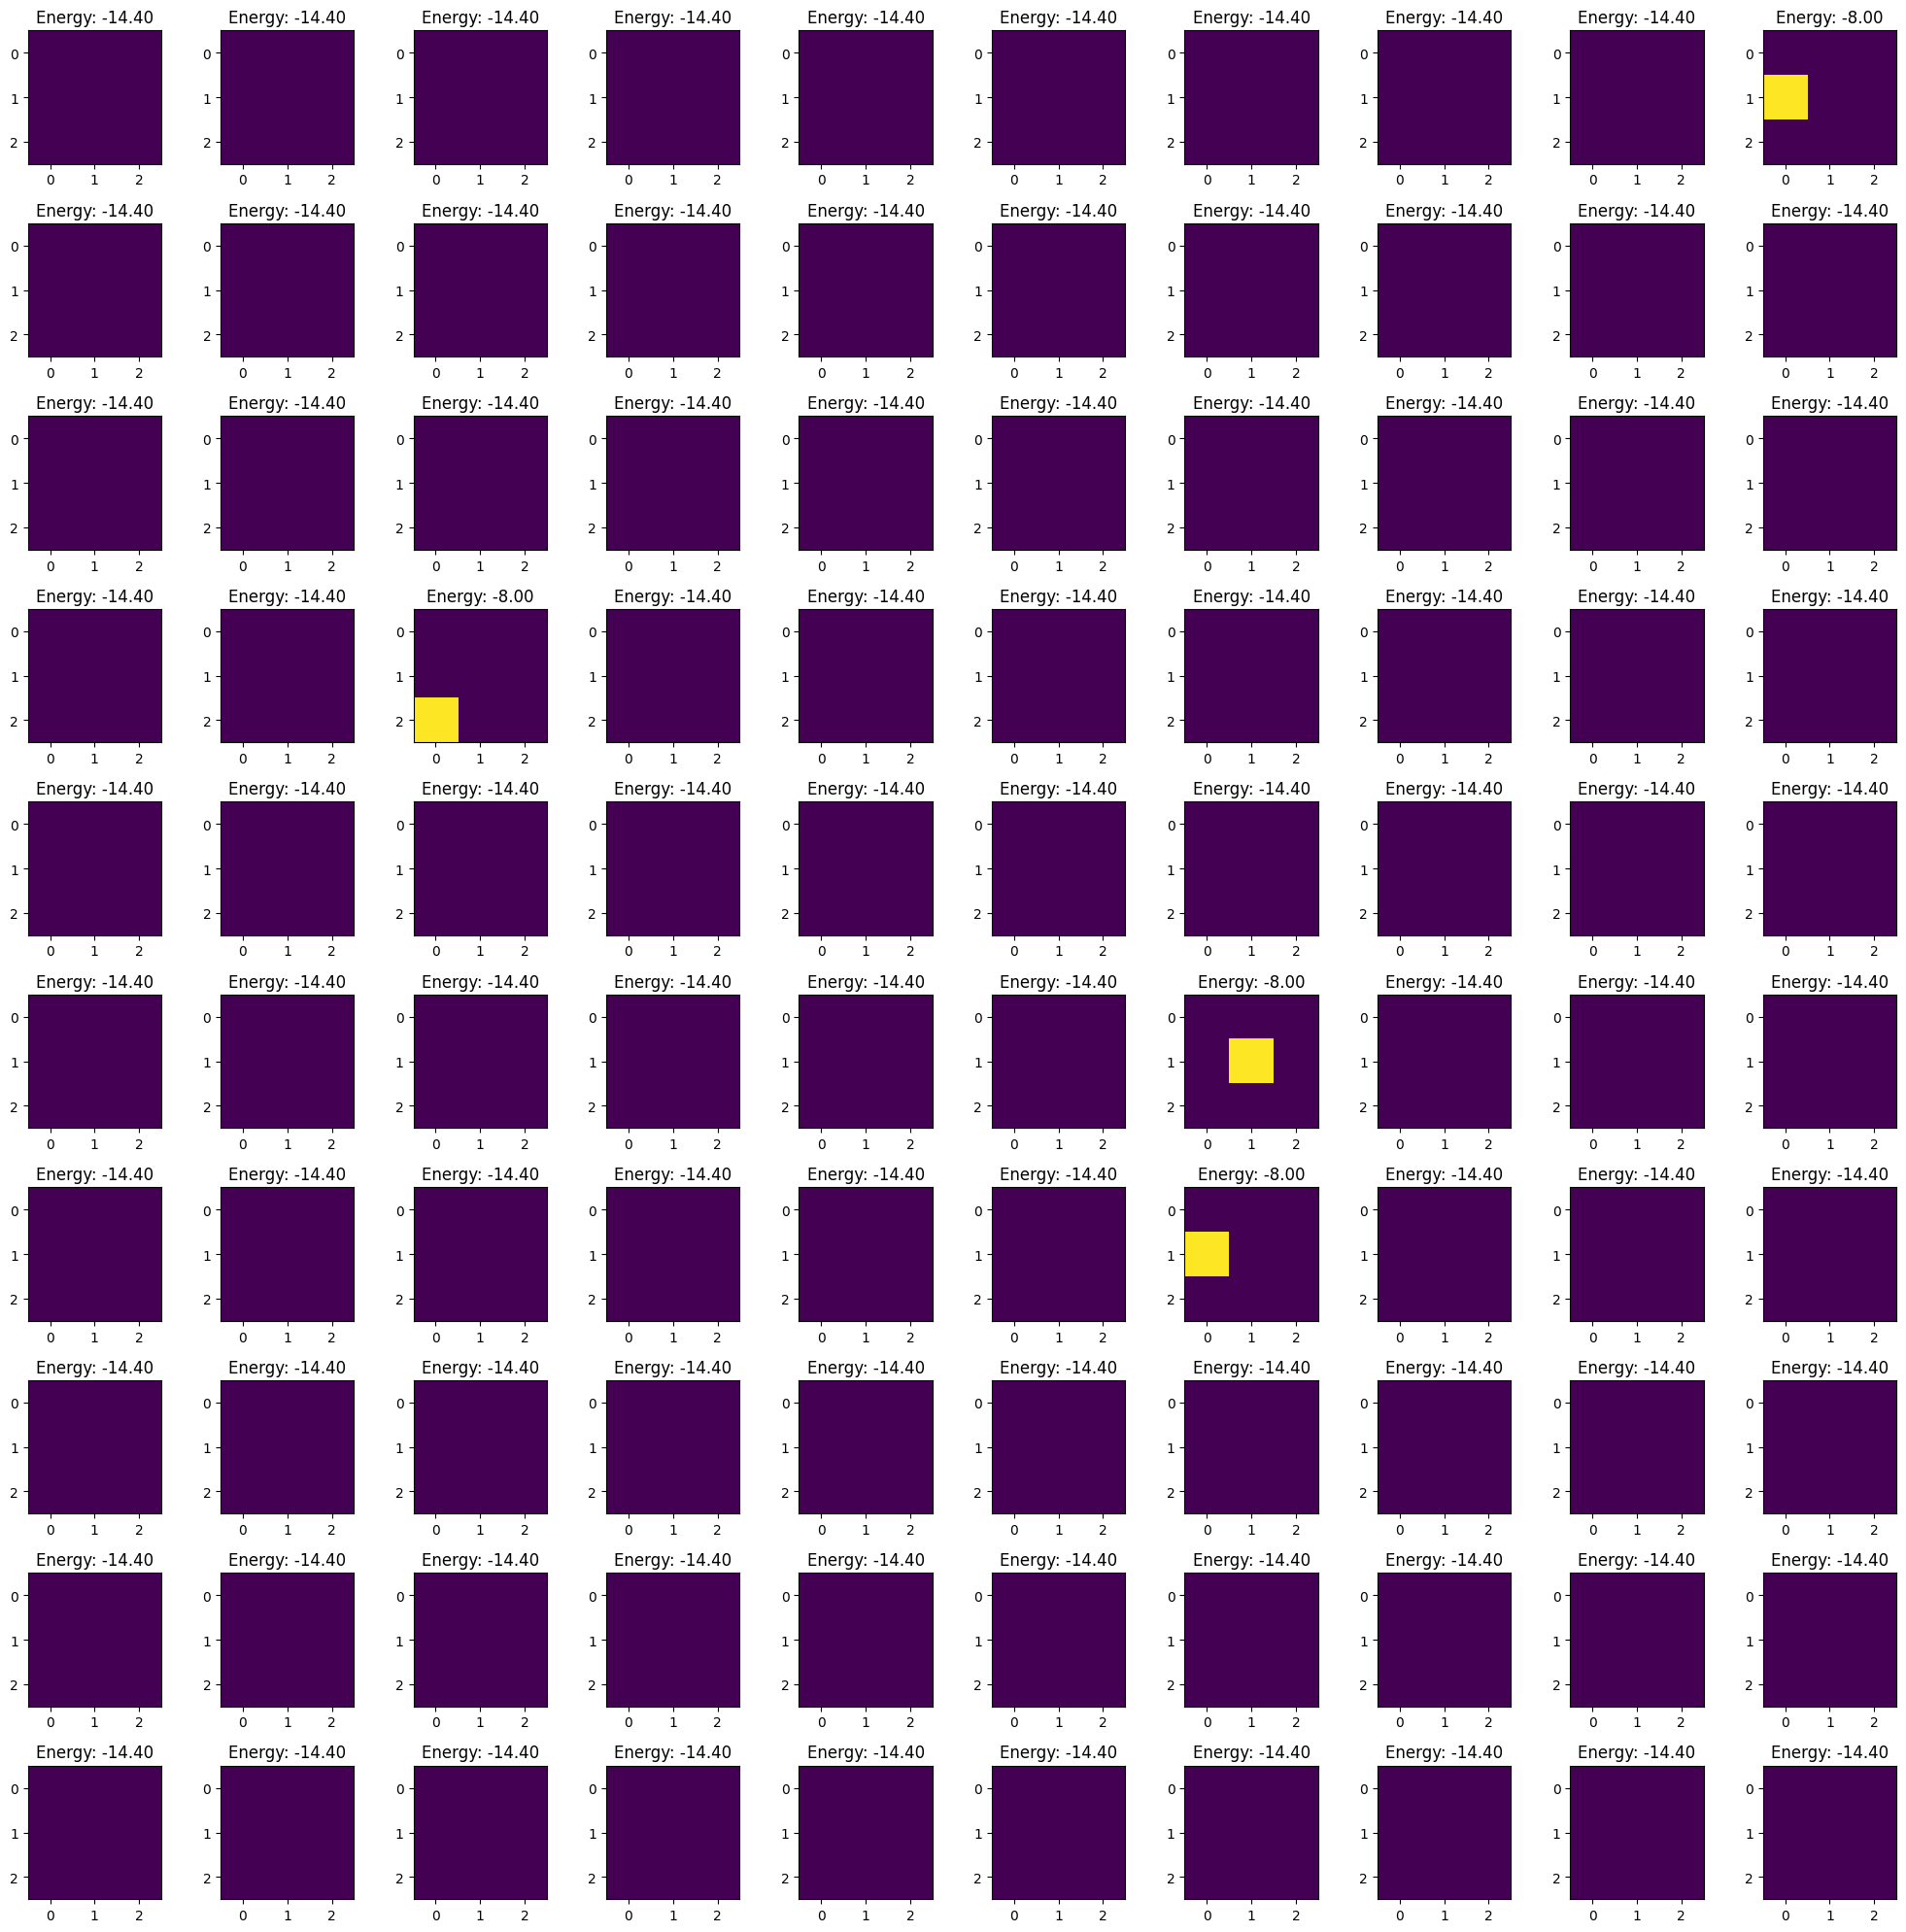

In [43]:
fig, axs = plt.subplots(figsize=(20, 20), ncols=10, nrows=10)
for i, sp in enumerate(spins):
    axs[i//10][i%10].imshow(sp.values)
    axs[i//10][i%10].set_title("Energy: {:3.2f}".format(energies[i]))
plt.tight_layout()